# Tennis Stroke Classification Project 🎾

This project aims to classify tennis strokes using a combination of machine learning and deep learning models, leveraging both an automatically generated and a manually relabeled dataset. The dataset consists of ~12,850 1-second video clips from 27 Grand Slam matches, each transformed into 20x12 action images. The dataset was relabeled manually to ensure accuracy, focusing on four classes: forehand, backhand, serve, and an "other" category for miscellaneous actions.

**What's an Action Image?**

An action image is a visual representation created from a 1-second-long video clip using pose estimation methods. In this project, each video is transformed into a 20x12 image with 3 channels (RGB). Specifically, the transformation is done using Ultralytics' pose estimation model ([Ultralytics GitHub](https://github.com/ultralytics/ultralytics)).

- **20:** Refers to the 20 frames extracted from the 1-second video, where the pose of the player is tracked.
- **12:** Refers to the 12 key pose points that were identified as relevant for the classification task:
  - 5: Left Shoulder
  - 6: Right Shoulder
  - 7: Left Elbow
  - 8: Right Elbow
  - 9: Left Wrist
  - 10: Right Wrist
  - 11: Left Hip
  - 12: Right Hip
  - 13: Left Knee
  - 14: Right Knee
  - 15: Left Ankle
  - 16: Right Ankle

This process of converting videos into action images is based on pose estimation, where each frame provides key information about the player's movements.

## Models

We explore several models, including Logistic Regression, SVM, Boosting, MLP, and CNNs. Each model was tested on both the initial and cleaned datasets.

## Results Overview

The CNNs performed better than the other models, showing that it could handle new, unseen data very well. However, the simpler models also did a great job.

| Model        | Dataset  | Accuracy | F1 Score (macro) |
|--------------|----------|----------|------------------|
| Logistic Reg | Cleaned  | 0.91     | 0.89             |
| SVM          | Cleaned  | 0.93     | 0.92             |
| MLP          | Cleaned  | 0.92     | 0.90             |
| CNN1 (50 e)  | Cleaned  | 0.96     | 0.96             |
| CNN1 (100 e) | Cleaned  | 0.96     | 0.96             |
| CNN2 (100 e) | Cleaned  | **0.97** | **0.96**         |

## Important Notes

Please refer to the main `README` file for all setup and installation instructions. It's important to use the **Tennis AI** kernel in Jupyter notebooks, which is explained in the `README`.


In [1]:
import pandas as pd
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import json
from tqdm import tqdm
import subprocess
from IPython.display import Video
import pickle

from ultralytics import YOLO

from utils import *
from nets import TennisStrokeCNNClassifier1, TennisStrokeCNNClassifier2

# Load Examples and YOLO Pose Estimation Model

List of options for the YOLO constructor:

| Model              | Size (pixels) | mAPpose 50-95 | mAPpose 50 | Speed (CPU ONNX) (ms) | Speed (A100 TensorRT) (ms) | Params (M) | FLOPs (B) |
|--------------------|---------------|---------------|------------|-----------------------|----------------------------|------------|-----------|
| yolov8n-pose.pt    | 640           | 50.4          | 80.1       | 131.8                 | 1.18                       | 3.3        | 9.2       |
| yolov8s-pose.pt    | 640           | 60.0          | 86.2       | 233.2                 | 1.42                       | 11.6       | 30.2      |
| yolov8m-pose.pt    | 640           | 65.0          | 88.8       | 456.3                 | 2.00                       | 26.4       | 81.0      |
| yolov8l-pose.pt    | 640           | 67.6          | 90.0       | 784.5                 | 2.59                       | 44.4       | 168.6     |
| yolo8x-pose.pt     | 640           | 69.2          | 90.2       | 1607.1                | 3.73                       | 69.4       | 263.2     |
| yolo8x-pose-p6.pt  | 1280          | 71.6          | 91.2       | 4088.7                | 10.04                      | 99.1       | 1066.4    |


You can read more about pose estimation models here: https://docs.ultralytics.com/tasks/pose/#models

In [2]:
examples_dir = 'examples/'
filepaths = load_examples(examples_dir)
model = YOLO("yolov8x-pose-p6.pt")  # download will start automatically (yolov8n-pose.pt is the smallest model)

# Load Videos and Resample to 20 Frames

The videos are resampled to 20 frames to ensure consistency across the dataset. This standardization simplifies data processing by removing variability in frame rates and video lengths.

In [3]:
resampled_paths = []

for i in tqdm(range(len(filepaths)), desc="Processing videos", unit="video"):
    frames = extract_frames(filepaths[i])
    resampled_frames = resample_frames(frames)
    output_folder = os.path.join("temp/resampled")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_path = os.path.join(output_folder, os.path.basename(filepaths[i]))
    write_video(output_path, resampled_frames)
    resampled_paths.append(output_path)

Processing videos: 100% 10/10 [00:03<00:00,  2.71video/s]


In [4]:
print(f'{len(filepaths)} videos loaded')

10 videos loaded


# Choose Video ID

Choose a specific video ID for a cleaner and more streamlined visualization.

In [5]:
# The video (m016_p016_bh01_serve_bottom_Carlos_Alcaraz) is included in the examples
# to test how the model performs on completely unseen data, as videos with this angle
# were excluded during the relabeling process.

FILE_ID = 9
fp = resampled_paths[FILE_ID]

# Pose Estimation

- You can select either a single video or multiple videos (to prepare all at once for later testing), depending on the processing power available. 

- **The classification models are optimized for a specific pose estimation model (`yolov8x-pose-p6.pt`), so results from other pose estimation models should not be considered fully reliable for later stages of this pipeline. However, our testing showed that even simpler models, even the simplest one `yolov8n-pose.pt`, performed quite well.**

- **List of all json pose estimation output files for the best model is also provided, you just need to change `json_path` variable below with `'json_best_pose'`.**

In [6]:
json_path = 'temp/json'

In [7]:
# estimate_poses(resampled_paths, model, json_path)  # Run for all examples at once
estimate_poses(resampled_paths[FILE_ID], model, json_path)

Processing videos:   0% 0/1 [00:00<?, ?it/s]/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Processing videos: 100% 1/1 [00:20<00:00, 20.53s/it]


# Pose Estimation Visualization

In [8]:
# prepare video for viz
pose_video = 'temp/temp_pose.mp4'
json_fpath = os.path.join(json_path, os.path.basename(fp).replace('.mp4', '.json'))

draw_bounding_boxes_on_video(fp, pose_video, json_fpath, draw_bb=False, draw_pose=True)

# input_video = filepaths[0]
output_video = 'temp/temp_output.mp4'

if os.path.exists(output_video):
    print(f"Output file {output_video} already exists. Deleting it.")
    os.remove(output_video)

ffmpeg_command = [
    'ffmpeg', '-i', pose_video,
    '-vcodec', 'libx264', '-acodec', 'aac',
    '-vf', 'scale=640:480',  # Resizing the video (optional)
    output_video
]

subprocess.run(ffmpeg_command, check=True)
os.remove(pose_video)

Output file temp/temp_output.mp4 already exists. Deleting it.


ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [9]:
Video(output_video, width=640, height=480, embed=True)

# Detect Bottom Player

We focus on the bottom player, using pose data to identify which poses belong to the player at the bottom of the screen.

**Using simpler models increases the likelihood of errors due to inconsistent pose estimation results over the duration of the video. This is the part where issues are most likely to occur.**

In [10]:
try:
    bottom_player_pose_data = get_bottom_player_pose_data(fp, json_folder=json_path)
    print('Success!')
except:
    print('Bad behaviour detected! Please select another video or use a more accurate pose estimation model.')

Success!


# Transform Video to Action Image

The video is turned into an action image by extracting 20 frames and tracking key pose points. These frames are combined into a single image, showing the player's movements over time.

The concept is based on the approach described in this paper, where video frames are transformed into a single action image by capturing key pose points over time: https://arxiv.org/abs/1704.05645 (***Skeleton based action recognition using translation-scale invariant image mapping and multi-scale deep cnn***). Note that the red and green channels in the image represent the x and y coordinates of the keypoints, while the blue channel represents the confidence level of those keypoints.

In [11]:
action_image = create_action_image(bottom_player_pose_data)

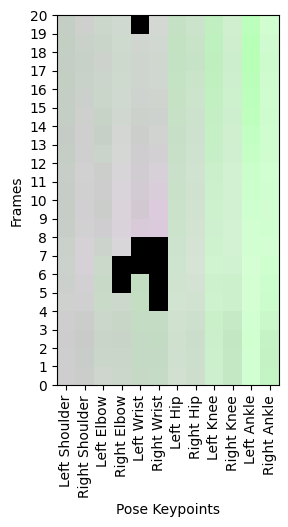

In [12]:
joint_labels = [
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]
label_positions = np.arange(0.5, 12.5, 1)
plt.imshow(action_image, extent=[0, 12, 0, 20], origin='lower')
plt.xticks(label_positions, joint_labels, rotation=90)
plt.yticks(np.arange(0, 21, 1))
plt.xlabel('Pose Keypoints')
plt.ylabel('Frames')
plt.show()

# Try All Classication Models

## Basic Models (Logistic Regression, SVM, Boosting, MLP)

- Each model has been developed using two versions of the dataset:
    1. Automatically generated dataset – obtained through the automated process.
    2. Relabeled dataset – manually reviewed and corrected for errors across all 12,850 video clips from 27 Grand Slam matches.

In [13]:
logistic_regression_model_init = load_pickle_model('../../models/00_logistic_regression_original_data.pkl')
logistic_regression_model = load_pickle_model('../../models/01_logistic_regression_clean_data.pkl')

svm_model_init = load_pickle_model('../../models/02_svm_original_data.pkl')
svm_model = load_pickle_model('../../models/03_svm_relabeled_data.pkl')

gradient_boosting_model = load_pickle_model('../../models/04_boosting_original_data.pkl')

mlp_model_init = load_pickle_model('../../models/06_mlp_original_data.pkl')
mlp_model = load_pickle_model('../../models/07_mlp_relabeled_data.pkl')

## Run Predictions for Each Model

In [14]:
basic_img = prepare_img_for_basic_model(action_image)

log_reg_predictions_init = run_sklearn_model(logistic_regression_model_init, basic_img)
log_reg_predictions = run_sklearn_model(logistic_regression_model, basic_img)

svm_predictions_init = run_sklearn_model(svm_model_init, basic_img)
svm_predictions = run_sklearn_model(svm_model, basic_img)

gb_predictions = run_sklearn_model(gradient_boosting_model, basic_img)

mlp_predictions_init = run_sklearn_model(mlp_model_init, basic_img)
mlp_predictions = run_sklearn_model(mlp_model, basic_img)

print(f"Stroke type detected by Logistic Regression (Initial Data) is: {log_reg_predictions_init[0].upper()}")
print(f"Stroke type detected by Logistic Regression (Cleaned Data) is: {log_reg_predictions[0].upper()}")

print(f"Stroke type detected by SVM (Initial Data) is: {svm_predictions_init[0].upper()}")
print(f"Stroke type detected by SVM (Cleaned Data) is: {svm_predictions[0].upper()}")

print(f"Stroke type detected by Gradient Boosting is: {gb_predictions[0].upper()}")

print(f"Stroke type detected by MLP (Initial Data) is: {mlp_predictions_init[0].upper()}")
print(f"Stroke type detected by MLP (Cleaned Data) is: {mlp_predictions[0].upper()}")

Stroke type detected by Logistic Regression (Initial Data) is: BACKHAND
Stroke type detected by Logistic Regression (Cleaned Data) is: FOREHAND
Stroke type detected by SVM (Initial Data) is: BACKHAND
Stroke type detected by SVM (Cleaned Data) is: BACKHAND
Stroke type detected by Gradient Boosting is: BACKHAND
Stroke type detected by MLP (Initial Data) is: BACKHAND
Stroke type detected by MLP (Cleaned Data) is: BACKHAND


## CNNs

Four versions of CNNs were developed:
- Three with the same architecture: 
  - 1 on the original dataset (50 epochs)
  - 1 on the cleaned dataset (50 epochs)
  - 1 on the cleaned dataset (100 epochs)
- One with a different architecture on the cleaned dataset (100 epochs)

All CNNs trained on the cleaned dataset produced similar results.

In [15]:
cnn_1_original = load_cnn_model(TennisStrokeCNNClassifier1, '../../models/08_cnn_original_data_50ep.pth')
cnn_1_clean_50 = load_cnn_model(TennisStrokeCNNClassifier1, '../../models/08_cnn_relabeled_data_50ep.pth')
cnn_1_clean_100 = load_cnn_model(TennisStrokeCNNClassifier1, '../../models/08_cnn_relabeled_data_100ep.pth')
cnn_2_clean_100 = load_cnn_model(TennisStrokeCNNClassifier2, '../../models/09_cnn_2_relabeled_data_100ep.pth')

In [16]:
cnn_img = prepare_img_for_cnn(action_image)

cnn1_prediction_orig = run_cnn_model(cnn_1_original, cnn_img)
cnn1_prediction_50 = run_cnn_model(cnn_1_clean_50, cnn_img)
cnn1_prediction_100 = run_cnn_model(cnn_1_clean_100, cnn_img)
cnn2_prediction_100 = run_cnn_model(cnn_2_clean_100, cnn_img)

_, predicted_class_orig = torch.max(cnn1_prediction_orig, 1)
_, predicted_class_50 = torch.max(cnn1_prediction_50, 1)
_, predicted_class_100 = torch.max(cnn1_prediction_100, 1)
_, predicted_class_2_100 = torch.max(cnn2_prediction_100, 1)

In [17]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

print(f"Stroke detected by CNN (Original Data, 50 epochs) is: {class_labels[predicted_class_orig.item()].upper()}")
print(f"Stroke detected by CNN (Cleaned Data, 50 epochs) is: {class_labels[predicted_class_50.item()].upper()}")
print(f"Stroke detected by CNN (Cleaned Data, 100 epochs) is: {class_labels[predicted_class_100.item()].upper()}")
print(f"Stroke detected by CNN (Complex, Cleaned Data, 100 epochs) is: {class_labels[predicted_class_2_100.item()].upper()}")

Stroke detected by CNN (Original Data, 50 epochs) is: BACKHAND
Stroke detected by CNN (Cleaned Data, 50 epochs) is: BACKHAND
Stroke detected by CNN (Cleaned Data, 100 epochs) is: BACKHAND
Stroke detected by CNN (Complex, Cleaned Data, 100 epochs) is: BACKHAND
